In [ ]:
# !pip install torch-dreams  --upgrade
!pip install git+https://github.com/Mayukhdeb/torch-dreams  ## for testing only 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torch_dreams.dreamer import dreamer
import torchvision.models as models
plt.rcParams['figure.figsize'] = 5,5

In [ ]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model, device = 'cuda', quiet =  False)

In [ ]:
!wget -O test.jpg https://www.capturelandscapes.com/wp-content/uploads/2017/03/DSC2441-Panorama.jpeg

In [5]:
from torch_dreams.custom_image_param import custom_image_param

In [7]:
def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].mean()
        return -loss
    return custom_func

In [57]:
my_custom_func = make_custom_func(layer_number= 0, channel_number = 19)
layers_to_use = [model.Mixed_6b.branch1x1.conv]

In [58]:
param = custom_image_param(filename = 'test.jpg', device= 'cuda')

image_param = dreamy_boi.render(
    image_parameter= param,
    layers = layers_to_use,
    lr = 2e-4,
    grad_clip = 0.1,
    weight_decay= 1e-1,
    iters = 90,  ## mild
    custom_func = my_custom_func
)

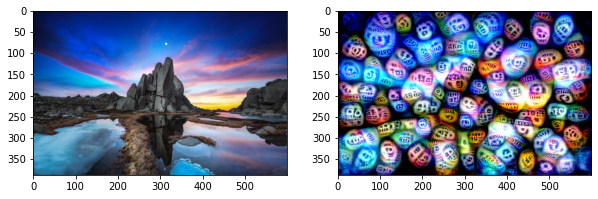

In [59]:
import cv2
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(10,5))
ax.flat[0].imshow(cv2.cvtColor(cv2.imread('test.jpg'), cv2.COLOR_BGR2RGB))
ax.flat[1].imshow(image_param)

In [60]:
from torch_dreams.utils import resize_4d_tensor_by_size    
import torch.nn as nn
from tqdm import tqdm
import torch

In [61]:
class CropAndResize(nn.Module):
    def __init__(self, crop = 3):
        super().__init__()
        self.crop = crop 

    def forward(self,x):
        """
        expects an NCHW tensor
        """
        x_cropped = x[:,:, self.crop:-self.crop, self.crop:-self.crop]
        x_resized = resize_4d_tensor_by_size(x_cropped, height = x.shape[-2], width = x.shape[-1])

        return x_resized

In [62]:
import imageio
def get_video_writer(filename, framerate):
    w = imageio.get_writer(filename, fps=framerate,)
    return w

In [63]:
writer = get_video_writer('test_crop_resize.mp4', framerate = 60)

param = custom_image_param(filename = 'test.jpg', device= 'cuda')

cropper = CropAndResize(crop = 1)

In [64]:

dreamy_boi.quiet = True

for i in tqdm(range(600)):
    param = dreamy_boi.render(
    image_parameter = param,
    layers = layers_to_use,
    lr = 2e-4,
    grad_clip = 0.1,
    weight_decay= 1e-1,
    iters = 2, 
    custom_func = my_custom_func
    )
    image_tensor = param.to_nchw_tensor()
    writer.append_data((param.to_hwc_tensor()*255).to(torch.uint8).numpy())
    new_image_tensor = cropper(image_tensor)

    param.set_param(tensor = new_image_tensor)

100%|██████████| 600/600 [01:33<00:00,  6.44it/s]


In [65]:
writer.close()

In [66]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('test_crop_resize.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=900 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)